*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Online learning in Lava

_**Motivation**: In this tutorial, we will demonstrate usage of a software model of Loihi's learning engine, exposed in Lava. This involves the LearningRule object for learning rule and other learning-related information encapsulation and the LearningDense Lava Process modelling learning-enabled connections._

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with the [ProcessModel concept in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

This tutorial gives a bird's-eye view of how to develop custom learning rules for Loihi. For this purpose, we will create a network of LIF and Dense processes with one plastic connection and generate frozen patterns of activity. We can easily choose between a floating point simulation of the learning engine and a fixed point simulation, which approximates the behavior on the Loihi neuromorphic hardware. We also will create monitors to observe the behavior of the weights and activity traces of the neurons and learning rules.


## 2. Loihi's learning engine
Loihi provides a programmable learning engine that can evolve synaptic state variables over time as a function of several locally available parameters and the equations relating input terms to output synaptic target variables are called _learning rules_. These learning rule equations are highly configurable but are constrained to a sum of products form.

#### Epoch-based updates
For efficiency reasons, trace and synaptic variable updates proceed in learning epochs with a length of $t_{epoch}$ time steps. Within an epoch, spike events are recorded but trace and synaptic variable updates are only computed and applied with a slight delay at the end of the epoch. This delayed application will theoretically not have any impact as long as there is only one spike per synapse and per epoch.

#### Synaptic variables
For each synapse, Loihi's computational model defines a set of three synaptic state variables that can be modified by the learning engine. These are :
- Weight $W$, representing _synaptic efficacy_.
- Delay $D$, representing _synaptic delay_.
- Tag $T$, which is an additional synaptic variable that allows for constructing more complex learning dynamics.

#### Learning rules
The amount of change by which a target synaptic variable is updated at the end of a learning epoch is given by the learning rule associated with said variable. The rules are specified in sum-of-products form:

$$Z \in \{W, D, T\}$$

$$dZ = \sum_{i = 1}^{N_P} D_i \cdot \left[ S_i \cdot \prod_{j = 1}^{N_F^i} F_{i, j} \right]$$

The learning rule consists in a _sum_ of $N_P$ _products_. Each $i$'th product is composed of a dependency operator $D_i$, a scaling factor $S_i$ and a sub-product of $N_F^i$ factors with $F_{i, j}$ denoting the $j$'th factor of the current product.

#### Dependencies
Each product is associated with a _dependency_ operator $D_i$ that conditions the evaluation of a product on the presence of a pre- or post-synaptic spike during the past epoch or evaluates a product unconditionally every other epoch. $D_i$ also determines at what time step during an epoch, all trace variables in the associated product are evaluated. The table below lists the various dependency operators and their behavior:

| Dependency | $t_{eval}$ | Description |
| :- | :- | :- |
| $x_0$ | $t_x$ | Conditioned on at least one pre-synaptic spike during epoch. |
| $y_0$ | $t_y$ | Conditioned on at least one post-synaptic spike during epoch. |
| $u_{\kappa}$ | $t_{epoch}$ | Unconditionally executed every $\kappa \cdot t_{epoch}$ time steps. |

#### Scaling factors
Each product is also associated with a _scaling factor_ (constant literal) that is given in mantissa/exponent form :

$$S_i = S_i^{mant} \cdot 2^{S_i^{exp}}$$

#### Factors
Furthermore, Loihi provides a set of locally available quantities which can be used in learning rule to derive synaptic variable updates. The table below lists the various types of variables whose value $F_{i, j}$ can assume:

| Factor | Description |
| :- | :- |
| $$x_0 + C$$ | Pre-synaptic spike. |
| $$x_1(t_{eval}) + C$$ | Pre-synaptic trace $x_1$. |
| $$x_2(t_{eval}) + C$$ | Pre-synaptic trace $x_2$. |
| $$y_0 + C$$ | Post-synaptic spike. |
| $$y_1(t_{eval}) + C$$ | Post-synaptic trace $y_1$. |
| $$y_2(t_{eval}) + C$$ | Post-synaptic trace $y_2$. |
| $$y_3(t_{eval}) + C$$ | Post-synaptic trace $y_3$. |
| $$W + C$$ | Weight synaptic variable $W$. |
| $$D + C$$ | Delay synaptic variable $D$. |
| $$T + C$$ | Tag synaptic variable $T$. |
| $$sgn(W + C)$$ | Sign of $W$. |
| $$sgn(D + C)$$ | Sign of $D$. |
| $$sgn(T + C)$$ | Sign of $T$. |
| $$C$$ | Constant term _(variant 1)_. |
| $$C^{mant} \cdot 2^{C^{exp}}$$ | Constant term _(variant 2)_. |

#### Traces
Traces are low-pass filtered versions of spike train that are typically used in online implementations of [Spike-Timing Dependent Plasticity (STDP)](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity "Spike-Timing Dependent Plasticity"). For each synapse, Loihi provides a set of **2 pre-synaptic traces** $\{x_1, x_2\}$ and **3 post-synaptic traces** $\{y_1, y_2, y_3\}$. The dynamics of an ideal spike trace is given by :

$$z \in \{x_1, x_2, y_1, y_2, y_3\}$$

$$z(t) = z(t_{k-1}) \cdot exp(- \frac{t-t_{k-1}}{\tau^z}) + \xi^z \cdot \delta^{z}(t - t_k)$$

Here, the set $\{t_k\}$ are successive spike times at which the trace accumulates the spike impulse value $\xi^{z}$ while $\tau^z$ governs the speed of exponential decay between spike events. Finally, $\delta^z$ denotes the raw spike train associated with the trace $z$.

#### Example: Basic pair-based STDP

$$dW = S_1 \cdot x_0 \cdot y_1 + S_2 \cdot y_0 \cdot x_1$$

where $S_1 < 0$ and $S_2 > 0$.

### Create custom learning rule


#### Instantiating LearningRule

Next, we define a learning rule ($dw$) for the _weight_ synaptic variable. The learning rule is first written in string format and passed to the LearningRule object as instantiation argument. This string learning rule will get internally parsed, transformed into and stored as a _ProductSeries_, which is a custom data structure that is particularly well-suited for sum-of-products representation.

Here, we use the basic pair-based STDP learning rule defined by :

$$dw = -2 \cdot x_0 \cdot y_1 + 2 \cdot y_0 \cdot x_1$$

### Parameters

As a reminder, the main function of the LearningRule object is not only to encapsulate learning rules, but also other learning-related such as trace impulse values and decay constants for all of the traces as well as the length of the learning epoch. The following table lists the different fields of the LearningRule class:

| Field | Python type | Description |
| :- | :- | :- |
| `dw` | ProductSeries | Learning rule targetting the synaptic variable $W$. |
| `dd` | ProductSeries | Learning rule targetting the synaptic variable $D$. |
| `dt` | ProductSeries | Learning rule targetting the synaptic variable $T$. |
| `x1_impulse` | float | Trace impulse value associated with $x_1$ trace. |
| `x1_tau` | int | Trace decay constant associated with $x_1$ trace. |
| `x2_impulse` | float | Trace impulse value associated with $x_2$ trace. |
| `x2_tau` | int | Trace decay constant associated with $x_2$ trace. |
| `y1_impulse` | float | Trace impulse value associated with $y_1$ trace. |
| `y1_tau` | int | Trace decay constant associated with $y_1$ trace. |
| `y2_impulse` | float | Trace impulse value associated with $y_2$ trace. |
| `y2_tau` | int | Trace decay constant associated with $y_2$ trace. |
| `y3_impulse` | float | Trace impulse value associated with $y_3$ trace. |
| `y3_tau` | int | Trace decay constant associated with $y_3$ trace. |
| `t_epoch` | int | Learning epoch length. |

In [1]:
from lava.magma.core.learning.learning_rule import LoihiLearningRule

# Learning rule coefficient
on_pre_stdp = -2
on_post_stdp = 2

learning_rate = 1

# Trace decay constants
x1_tau = 10
y1_tau = 10

# Impulses
x1_impulse = 16
y1_impulse = 16

# Epoch length
t_epoch = 2

# Define dw as string
dw = f"{learning_rate} * ({on_pre_stdp}) * x0 * y1 +" \
     f"{learning_rate} * {on_post_stdp} * y0 * x1"

In [2]:
# Create custom LearningRule
stdp = LoihiLearningRule(dw=dw,
                         x1_impulse=x1_impulse,
                         x1_tau=x1_tau,
                         y1_impulse=y1_impulse,
                         y1_tau=y1_tau,
                         t_epoch=t_epoch)

### Network parameters

In [3]:
import numpy as np

# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "floating_pt"

# LIF parameters
if SELECT_TAG == "fixed_pt":
    du = 4095
    dv = 4095
elif SELECT_TAG == "floating_pt":
    du = 1
    dv = 1
vth = 240

# Number of neurons per layer
num_neurons = 1
shape_lif = (num_neurons, )
shape_conn = (num_neurons, num_neurons)

# Connection parameters

# SpikePattern -> LIF connection weight
wgt_inp = np.eye(num_neurons) * 250

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn, 50)
    
# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = 0.03

# Create spike rasters
np.random.seed(123)
spike_raster_pre = np.zeros((num_neurons, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

spike_raster_post = np.zeros((num_neurons, num_steps))
np.place(spike_raster_post, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

### Create Network
The following diagram depics the Lava Process architecture used in this tutorial. It consists of:
- 2 Constant pattern generators for injection spike trains to LIF neurons.
- 2 _LIF_ Processes representing pre- and post-synaptic Leaky Integrate-and-Fire neurons.
- 1 _Dense_ Process representing learning-enable connection between LIF neurons.

>**Note:** 
All neuronal population (spike generator, LIF) are composed of only 1 neuron in this tutorial.

<img src="https://raw.githubusercontent.com/lava-nc/lava-docs/main/_static/images/tutorial_learning/learning_tutorial_architecture.svg" alt="Architecture.svg" style="width: 70%;"/>

#### The plastic connection Process
We now instantiate our plastic Dense process. The Dense Process provides the following Vars and Ports relevant for plasticity:

| Component | Name | Description |
| :- | :- | :- |
| **InPort** | `s_in_bap` | Receives spikes from post-synaptic neurons.
| **Var** | `tag_2` | Delay synaptic variable.
|         | `tag_1` | Tag synaptic variable.
|         | `x0` | State of $x_0$ dependency.
|         | `tx` | Within-epoch spike times of pre-synaptic neurons.
|         | `x1` | State of $x_1$ trace.
|         | `x2` | State of $x_2$ trace.
|         | `y0` | State of $y_0$ dependency.
|         | `ty` | Within-epoch spike times of post-synaptic neurons.
|         | `y1` | State of $y_1$ trace.
|         | `y2` | State of $y_2$ trace.
|         | `y3` | State of $y_3$ trace.



In [4]:
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import LearningDense as Dense

In [5]:
# Create input devices
pattern_pre = RingBuffer(data=spike_raster_pre.astype(int))
pattern_post = RingBuffer(data=spike_raster_post.astype(int))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp)
conn_inp_post = Dense(weights=wgt_inp)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif,
              name='lif_pre')

# Create plastic connection
plast_conn = Dense(weights=wgt_plast_conn,
                   learning_rule=stdp,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = LIF(u=0,
               v=0,
               du=du,
               dv=du,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating actionpotential (BAP)
lif_post.s_out.connect(plast_conn.s_in_bap)

### Create monitors to observe traces

In [6]:
from lava.proc.monitor.process import Monitor

In [7]:
# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)

### Running

In [8]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

In [9]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi1SimCfg(select_tag=SELECT_TAG))

In [10]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights = mon_weight.get_data()['plastic_dense']['weights'][:, :, 0]

In [11]:
# Stopping
pattern_pre.stop()

### Results

Now, we can take a look at the results of the simulation. 

In [12]:
import matplotlib.pyplot as plt

#### Plot spike trains

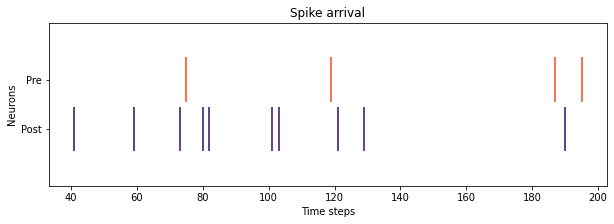

In [13]:
# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(10, 3))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)
    
    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]], 
            legend=['Post', 'Pre'], 
            colors=['#370665', '#f14a16'])

#### Plot traces

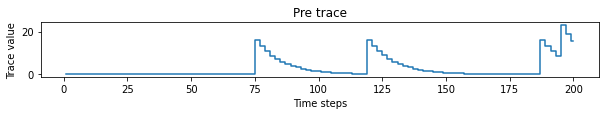

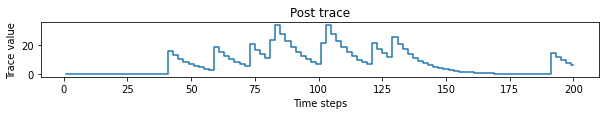

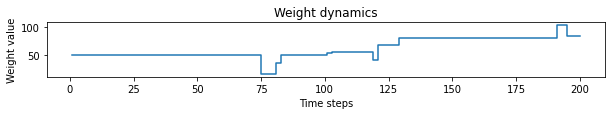

In [14]:
# Plotting trace dynamics
    
def plot_time_series(time, time_series, ylabel, title):
    plt.figure(figsize=(10, 1))
    
    plt.step(time, time_series)
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    
    plt.show()
    
# Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre trace")
# Plotting post trace dynamics
plot_time_series(time=time, time_series=post_trace, ylabel="Trace value", title="Post trace")
# Plotting weight dynamics
plot_time_series(time=time, time_series=weights, ylabel="Weight value", title="Weight dynamics")

#### Plot STDP learning window and weight changes

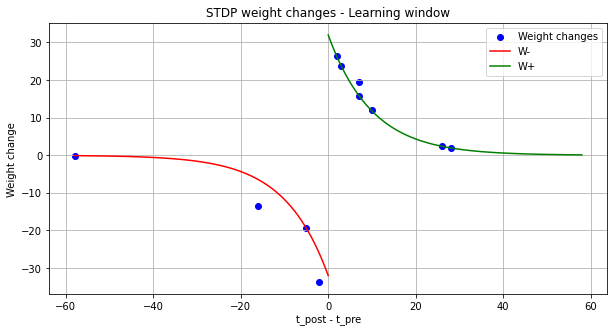

In [15]:
def extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt):
    # Compute the weight changes for every weight change event
    w_diff = np.zeros(wgt.shape)
    w_diff[1:] = np.diff(wgt)

    w_diff_non_zero = np.where(w_diff != 0)
    dw = w_diff[w_diff_non_zero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(time)
    t_non_zero = time[w_diff_non_zero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikes_pre = np.array(spikes_pre)
    spikes_post = np.array(spikes_post)
    dt = []
    for i in range(0, len(dw)):
        time_stamp = t_non_zero[i]
        t_post = (spikes_post[np.where(spikes_post <= time_stamp)])[-1]
        t_pre = (spikes_pre[np.where(spikes_pre <= time_stamp)])[-1]
        dt.append(t_post-t_pre)

    return np.array(dt), np.array(dw)
    
def plot_stdp(time, spikes_pre, spikes_post, wgt, 
              on_pre_stdp, y1_impulse, y1_tau, 
              on_post_stdp, x1_impulse, x1_tau):
    # Derive weight changes as a function of time differences
    diff_t, diff_w = extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt)
    
    # Derive learning rule coefficients
    on_pre_stdp = eval(str(on_pre_stdp).replace("^", "**"))
    a_neg = on_pre_stdp * y1_impulse
    on_post_stdp = eval(str(on_post_stdp).replace("^", "**"))
    a_pos = on_post_stdp * x1_impulse
    
    # Derive x-axis limit (absolute value)
    max_abs_dt = np.maximum(np.abs(np.max(diff_t)), np.abs(np.min(diff_t)))
    
    # Derive x-axis for learning window computation (negative part)
    x_neg = np.linspace(-max_abs_dt, 0, 1000)
    # Derive learning window (negative part)
    w_neg = a_neg * np.exp(x_neg / y1_tau)
    
    # Derive x-axis for learning window computation (positive part)
    x_pos = np.linspace(0, max_abs_dt, 1000)
    # Derive learning window (positive part)
    w_pos = a_pos * np.exp(- x_pos / x1_tau)
    
    plt.figure(figsize=(10, 5))
    
    plt.scatter(diff_t, diff_w, label="Weight changes", color="b")
    
    plt.plot(x_neg, w_neg, label="W-", color="r")
    plt.plot(x_pos, w_pos, label="W+", color="g")
    
    plt.title("STDP weight changes - Learning window")
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
    plt.legend()
    plt.grid()
    
    plt.show()

# Plot STDP window
plot_stdp(time, np.where(pre_spikes[:, 0]), np.where(post_spikes[:, 0]), weights[:, 0], 
          on_pre_stdp, stdp.y1_impulse, stdp.x1_tau, 
          on_post_stdp, stdp.x1_impulse, stdp.y1_tau)

### How to learn more?

Find out how to use STDP from the Lava ProcessLibrary in the [STDP Tutorial](../../in_depth/tutorial09_custom_learning_rules.ipynb "Tutorial on custom learning rules").

#### Follow the links below for deep-dive tutorials on the concepts in this tutorial:
- [Processes](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](../../in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](../../in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Connecting Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/ "Lava Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").